In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pylab as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader

device = 'cuda:0' if torch.cuda.is_available() else "cpu"

def gen_data(N=100, d=10, low=0, high=10):
    data = np.random.randint(low=low, high=high, size=(N,d))
    
    target_idx = np.random.randint(low=0, high=d, size=N).reshape(data.shape[0], 1)
    
    full_data = np.hstack((data, target_idx))
    
    y = data[np.arange(data.shape[0]), target_idx[:,0]]
    
    return full_data, y

N = 5000
low = 0 
high = 10
d = 10

train_data, train_target = gen_data(N=N, low=low, high=high, d=d)
test_data, test_target = gen_data(N=N, low=low, high=high, d=d)

In [2]:
print(train_data.shape) #last column is the actual index value and not part of the array
print(train_target.shape)

(5000, 11)
(5000,)


## Recurrent Neural Networks (RNN)

An RNN will process a sequence of tokens. The pseudocode is something like the following:

token_list = [...]

hidden_vec = [0, ..., 0] #some fixed length or dimensionality

for token in token_list:

#lookup vector for each token from a hash table
    token_vec = embedding_table[token]
    
    #use previous hidden_vec and current token_vec to update hidden_vec
    #this is updating the state (hidden_vec) of the net using the new token
    
    hidden_vec = update(hidden_vec/previous state, token_vec/new data)
    
after the loop, hidden_vec encodes all the information about the input sequence and can be used to make a prediction

prediction = pred(hidden_vec)

for us, this could also be

prediction = pred(hidden_vec, index)

if the task is to predict the entry at a particular index

### Embedding

Suppose, we were working with natural text where the tokens were words. To feed in a word like "apple" to a neural network, we need to "numericalize" (i.e. convert it to a number) it.

The simplest solution is to map each unique token to a unique integer. For example:

"apple" -> 0

"is" -> 1

"a" -> 2

etc.

Note that the only requirement is that this mapping is one-to-one i.e. different words are mapped to different integers. The actual mapping, i.e. whether "apple" -> 0 or "apple" -> 59, doesn't matter.

Are there any problems with this encoding of tokens? One immediate problem is that it imposes an ordering on the tokens. "apple" is not less than "a" but 2 < 0. Depending on the machine learning model used, this ordered encoding can induce artifacts that are not real.

The solution to this problem is the so-called one-hot encoding. Suppose, there are N distinct words. Each word is mapped to a vector of size N where exactly one entry is 1 and the rest are zeros. Suppose, N = 3. Then,

"apple" -> [1,0,0]

"is" -> [0,1,0]

"a" -> [0,0,1]

Now, there is no order imposed on the tokens. Each vector is orthogonal to all other vectors (the dot product of vectors corresponding to distinct words is 0). This creates a couple of problems. If the number of tokens is large, the dimensionality N will also be large and this has implications for memory usage. Another problem is more conceptual. While each word is distinct (by definition) from every other word, words are not distinct by meaning. "apple" and "mango" are similar in the sense that they are both fruits but they are clearly also distinct (winter vs summer fruit etc.). Since vectors can be used to encode similarity, is it possible to map tokens to vectors such that (a) similar meaning words map to similar vectors and (b) dissimilar meaning words map to dissimilar vectors.

This is the problem embeddings solve. The philosophy in neural networks is to map each token to a unique vector is a relatively small (compared to the number of distinct tokens, N) dimensional (128 below) vector space. The embeddings are initialized randomly but are also adjusted during the learning process using the same exact process used to adjust/learn weights i.e. by computing derivatives and using gradient descent.

In [ ]:
embedding_dim = 128
emb = nn.Embedding(num_embeddings=high-low, embedding_dim=128)

In [ ]:
#can now look up embedding vectors based on input token (any value between low and high-1)

emb(torch.tensor(0))

In [ ]:
emb(torch.tensor(high-1))

In [ ]:
#only values between low and high-1 have entries in the table
emb(torch.tensor(high))

### RNN definition

The code below defines the recurrent neural network. There are three broad classes of RNNs:

1. Vanilla RNNs - these tend to have a problem learning long-range behavior if the sequences are long. This is due to the so-called exploding and vanishing gradients problem (don't worry about this for now).

2. Long short-term memory networks (LSTMs): instead of having just one (hidden) state like RNNs, LSTMs maintain a long-term memory vector and a short-term memory vector. The coarse idea is to use the long-term memory vector to "remember" long-range patterns.

3. Gated Recurrent Units (GRUs): A simpler (less parameters/weights) form of LSTMs with the same underlying idea.

(We can go over the details in a call)

We will also use "attention". The core idea of attention is described below.

As an RNN processes an input sequence (sentence or byte vector), it generates a sequence of hidden vectors.

$$h_1, h_2, \ldots, h_T$$

where T = length of sequence.

The final hidden state is then used as a measure of context for any downstream tasks (predicting an output sequence or predicting a class for the sequence).

Attention refers to the idea that the context shouldn't consist just of $h_T$ but should be dynamic/flexible. 

For more details, either see the code below or the notes on attention near the end of this notebook.

#### First, experiment with an LSTM to understand shapes of various tensors

In [ ]:
#see: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
rnn = nn.LSTM(input_size = 128, #dimension of embedding
              hidden_size = 32, #
              num_layers = 2,
              batch_first = True, #expect (batch, seq, feature)
              dropout = 0.5,
              bidirectional=True                             
             )

In [ ]:
#want to understand data flow. pick some input data
inp = torch.from_numpy(train_data[0:5, :-1])
inp.shape #(batch/sequence number, length/time)

In [ ]:
emb(inp).shape #(batch/sequence number, length/time, embedding feature)

In [ ]:
print(type(rnn(emb(inp))))
len(rnn(emb(inp)))

In [ ]:
print(type(rnn(emb(inp))[0]))
print(rnn(emb(inp))[0].shape) #(batch/sequence number, length/time, embedding feature*2 for bidirectional)

In [ ]:
print(type(rnn(emb(inp))[1]))
print(len(rnn(emb(inp))[1]))

In [ ]:
print(type(rnn(emb(inp))[1][0]))
print(rnn(emb(inp))[1][0].shape)

Why is the output above of shape (4,5,32)?

32 is the hidden dim i.e. the dimensionality of the hidden state and the cell state in an LSTM

5 is the number of sequences in the batch (if this is not convincing, try changing inp to have, say, 7 sequences)

where does the 4 come from? Claim: The 4 = 2 (num_layers) * 2 (bidirectional) cell states

Of course, we could have looked at the documentation:

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Outputs: outputs, (h_n, c_n)

where 

outputs.shape = (number of examples, length of sequence, 2*hidden_dim)

h_n.shape = (2*num_layers, number of examples, hidden_dim)

c_n.shape = (2*num_layers, number of examples, hidden_dim)

In [ ]:
print(type(rnn(emb(inp))[1][1]))
print(rnn(emb(inp))[1][1].shape)

**Mock run**:
    
It's generally a good idea to pick one training point (X, y pair) and run through the operations manually before defining the network architecture.

In [ ]:
#step 1: look at data

idx = 5

X = train_data[idx, :]
y = train_target[idx]

X1 = X[:-1]
X2 = X[-1]

print(X1, X2, y)

In [ ]:
#step 2: compute embeddings for one element of input sequence
low = 0
high = 10

embedding_dim = 128
emb = nn.Embedding(num_embeddings=high-low, embedding_dim=128)

emb(torch.from_numpy(X1)[3]) #can get embeddings for each element of X1

In [ ]:
#step 3: compute hidden states for one step of input sequence
o, (h_n,c_n) = rnn(emb(torch.from_numpy(X1)[3])[None,None,:]) #emb()[None, None, :] of shape (1,1,embedding_dim=128)

In [ ]:
print(o.shape)
print(h_n.shape)
print(c_n.shape)

In [ ]:
#step 4: compute over full sequence
print('raw:', torch.from_numpy(X1).shape) #(length of sequence)
print('raw unsqueeze:', torch.from_numpy(X1)[None, :].shape) #(1, length of sequence) where 1 is the number of sequences
print('emb:', emb(torch.from_numpy(X1)[None, :]).shape) #(1, length of sequence, embedding dim/input dim for rnn)

o, (h,c) = rnn(emb(torch.from_numpy(X1)[None, :]))
print('o:', o.shape) #(num of sequences = 1, length of sequence, 2 (bidirectional)*hidden_dim) #last layer, at every time-step
print('h:', h.shape) #(bidirection*num_layers, num of sequences = 1, hidden_dim) - at last time-step
print('c:', c.shape) #(bidirection*num_layers, num of sequences = 1, hidden_dim) - at last time-step

In [ ]:
#step 5: another embedding layer for index
#note: it would make sense for us to emb the position of each element in the input sequence and match the embedding
#of the index to the embeddings of the position
#note 2: if instead, we were doing a "semantic search", then embeddings of the search token would make more sense



emb_idx = nn.Embedding(num_embeddings=d, embedding_dim=128) #there are d unique index values

emb_idx(torch.tensor(X2))

In [ ]:
#step 6: learn a dense layer to map embedding of idx and compare to output values for a sequence

attn_lin = nn.Linear(128, 64) #128 is embedding_dim, 64 is bidirectional * hidden_dim (32)
attn_lin(emb_idx(torch.tensor(X2)))

In [ ]:
#step 7: compute attention scores

#7a: compute dot product of attn_lin(emb_idx()) with output

a = attn_lin(emb_idx(torch.tensor(X2))).unsqueeze(0) #in general, will be of shape (num sequences, 64)
print('a:', a.shape)

print('o:', o.shape)
energies = torch.tensordot(a, o, dims=([1], [2]))
print('energies:', energies.shape)
energies = energies.squeeze(1)
print('energies:', energies.shape) #(num sequences, length of sequence)
print(energies)

#7b: compute attention scores
scores = torch.exp(energies)
scores /= scores.sum(dim=1)
print('scores:', scores.shape)
print(scores)
print(scores.sum())

assert(torch.abs(scores.sum()-1.0) < 1e-5)

out = torch.tensordot(o, scores, dims=([1], [1])).squeeze(2) #weighted hidden state used to make predictions
print('out:', out.shape)

In [ ]:
#step 8: use out as input to small MLP to predict actual output

out_layer = nn.Linear(64, high-low)
out_activation = nn.Softmax(dim=1)
out_activation(out_layer(out)) #actual probability that input_seq[input_idx] takes each value between high-low

### Putting it all together

It is time to put these 8 steps together in one architecture. It's good practice to put assertions and sanity checks since we are composing many operations together.

The following cell generalizes the above calculation to a batch of data

**Exercise**: Go over each line, run it, make sure you understand why the shapes are what they are and how it corresponds to the attention mechanism described towards the end of this notebook.

In [ ]:
#step 1: pick a batch of 5 examples
X1 = train_data[4:9, :-1]
X2 = train_data[4:9, -1]
y = train_target[4:9]

print('\nData:')
print(X1, X2, y)
print(X1.shape, X2.shape, y.shape)

#step 2: data -> embddings -> LSTM -> get output activations (from final layer, for all time-steps)
o, (h,c) = rnn(emb(torch.from_numpy(X1)))
print('\nrnn outputs:')
print('o:', o.shape) #(num of sequences = 1, length of sequence, 2 (bidirectional)*hidden_dim) #last layer, at every time-step
print('h:', h.shape) #(bidirection*num_layers, num of sequences = 1, hidden_dim) - at last time-step
print('c:', c.shape) #(bidirection*num_layers, num of sequences = 1, hidden_dim) - at last time-step

#step 3: get embedding for index and use a linear layer to map it to 64 dimensions to compare to o
emb_idx = nn.Embedding(num_embeddings=d, embedding_dim=128) #there are d unique index values

attn_lin = nn.Linear(128, 64) #128 is embedding_dim, 64 is bidirectional * hidden_dim (32)


#step 4: compute attention scores
a = attn_lin(emb_idx(torch.tensor(X2))).unsqueeze(0) #in general, will be of shape (num sequences, 64)
a = a.permute(1,2,0) #change shape so we can multiply it
print('\na:', a.shape)

print('o:', o.shape)
energies = o @ a #batch matrix multiplication (torch.bmm)
print('energies:', energies.shape) #(num sequences, length of sequence, 1)

#compute $\alpha_{tj} i.e. probabilities
scores = torch.exp(energies)
scores = (scores / scores.sum(dim=1).unsqueeze(1))
print('scores:', scores.shape)

assert(scores.sum(dim=1).mean()==1) #by construction, should get a distribution over time-steps

out = (o * scores).sum(dim=1) #compute the linear combination (weighted average)
print('out:', out.shape)

#step 5: map the attention-weighted hidden activations to prob distribution over discrete output space
out_layer = nn.Linear(64, high-low)
out_activation = nn.Softmax(dim=1)
out_activation(out_layer(out)) #actual probability that input_seq[input_idx] takes each value between high-low

Now, it really is time to put it all together and define out neural network architecture

In [ ]:
torch.rand((64,10,1)).sum(dim=1).mean().item()

In [15]:
class Net(nn.Module):
    def __init__(self, low, high, emb_dim, hidden_size, num_layers=1):
        super().__init__()
        
        self.low = low
        self.high = high
        self.emb_dim = emb_dim
        
        self.emb = nn.Embedding(num_embeddings=high-low, embedding_dim=emb_dim)
        self.emb_idx = nn.Embedding(num_embeddings=high-low, embedding_dim=emb_dim)
        self.attn_lin = nn.Linear(emb_dim, hidden_size*2) #128 is embedding_dim, 64 is bidirectional * hidden_dim (32)
        self.out_layer = nn.Linear(hidden_size*2, high-low)
        
        #see: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.rnn = nn.LSTM(input_size = emb_dim,
                           hidden_size = hidden_size,
                           num_layers = num_layers,
                           batch_first = True, #expect (batch, seq, feature)
                           dropout = 0.5,
                           bidirectional=True                             
                          )
        
        self.pred = nn.Linear(2*hidden_size, high-low)
        
    def forward(self, x):
        X1 = x[:, :-1]
        X2 = x[:, -1]
        
        o, (h,c) = self.rnn(self.emb(X1))
        
        #attention - map index to appropriate dimensionality
        a = self.attn_lin(self.emb_idx(X2)).unsqueeze(0)
        a = a.permute(1,2,0) #change shape so we can multiply it
        
        #attention - compute energies (log probabilities)
        energies = o @ a #batch matrix multiplication (torch.bmm)

        #attention - compute scores
        #scores = torch.exp(energies)
        #scores = (scores / scores.sum(dim=1).unsqueeze(1))
        scores = nn.Softmax(dim=1)(energies)

        #print(scores.shape)
        if torch.abs(scores.sum(dim=1).mean()-1) > 1e-8: #by construction, should get a distribution over time-steps
            print(scores.sum(dim=1).mean())
            print(scores.sum(dim=1))
            import ipdb
            ipdb.set_trace()
            
        #attention - linear combination of encoder hidden states
        out = (o * scores).sum(dim=1)
        out = self.out_layer(out) #logits
    
        return out

In [16]:
emb_dim = 128
hidden_size = 32
num_layers = 2
model = Net(low, high, emb_dim, hidden_size, num_layers=num_layers)

In [17]:
X = train_data[4:9, :-1]
y = train_target[4:9]

model(torch.from_numpy(X)).shape #logits over output space for each sequence

torch.Size([5, 10])

### Training loop

In [18]:
class Array(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        X = torch.from_numpy(self.data[i])
        y = torch.tensor(self.targets[i])
        
        assert(X[X[-1]]==y)
        
        return X, y

In [19]:
ds_train = Array(train_data, train_target)
ds_test = Array(test_data, test_target)

In [20]:
dl_train = DataLoader(ds_train, batch_size=64)
dl_test = DataLoader(ds_test, batch_size=64)

In [21]:
a,b = next(iter(dl_train))
print(a.shape)
print(b.shape)

torch.Size([64, 11])
torch.Size([64])


In [22]:
emb_dim = 128
hidden_size = 32
num_layers = 2
model = Net(low, high, emb_dim, hidden_size, num_layers=num_layers)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(net, dl_train, dl_test, n_epochs, criterion, optimizer, device, print_freq=10):
    net.train()
    
    for i in range(n_epochs):
        for idx, (X, y) in enumerate(dl_train):
            X = X.to(device)
            y = y.to(device)
            
            pred = net(X)
            loss = criterion(pred, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            #nn.utils.clip_grad_norm_(net.parameters(), 10)
            for p in net.parameters():
                p.register_hook(lambda g: torch.clamp(g, -10, 10))
            
            grad_mean = check_grads(net)
            
            optimizer.step()
            
        if i % print_freq==0:
            train_acc = validate(net, dl_train)
            test_acc = validate(net, dl_test)
            
            #print(f'grad_mean = {grad_mean}')
            print(f'train acc = {train_acc} test acc = {test_acc}')
            net = net.train()
    return net

def validate(net, dl):
    net.eval()
    n_correct = 0
    n_total = 0
    
    with torch.no_grad(): #don't store gradients since we are not training here
        for i, (X,y) in enumerate(dl):
            X = X.to(device)
            y = y.to(device)
            
            pred = net(X) 
            
            #don't want just probabilities. pick class with maximum probability
            pred = torch.argmax(pred, dim=1)
            
            n_correct += (pred==y).sum()
            n_total += pred.shape[0]
            
    return n_correct/n_total

def check_grads(net):
    grads = []
    for p in net.parameters():
        if p.grad is not None:
            grads.append(p.grad.mean().detach().cpu().item())
            
    return np.mean(grads)

In [23]:
model = train(model, dl_train, dl_test, 10, criterion, optimizer, device=device, print_freq=1)

train acc = 0.4177999794483185 test acc = 0.3903999924659729
train acc = 0.5740000009536743 test acc = 0.5442000031471252
train acc = 0.722599983215332 test acc = 0.7008000016212463
train acc = 0.8736000061035156 test acc = 0.863599956035614
train acc = 0.9651999473571777 test acc = 0.9609999656677246
train acc = 0.9983999729156494 test acc = 0.996999979019165
train acc = 0.9835999608039856 test acc = 0.983199954032898
train acc = 0.9959999918937683 test acc = 0.9959999918937683
train acc = 0.9959999918937683 test acc = 0.9957999587059021
train acc = 1.0 test acc = 1.0


### Analyze attention scores

In [24]:
#this is a duplicate of the forward pass

def scores(x, net):
    X1 = x[:, :-1]
    X2 = x[:, -1]

    o, (h,c) = net.rnn(net.emb(X1))

    #attention - map index to appropriate dimensionality
    a = net.attn_lin(net.emb_idx(X2)).unsqueeze(0)
    a = a.permute(1,2,0) #change shape so we can multiply it

    #attention - compute energies (log probabilities)
    energies = o @ a #batch matrix multiplication (torch.bmm)

    #attention - compute scores
    #scores = torch.exp(energies)
    #scores = (scores / scores.sum(dim=1).unsqueeze(1))
    scores = nn.Softmax(dim=1)(energies)
    return scores

'''
#print(scores.shape)
if torch.abs(scores.sum(dim=1).mean()-1) > 1e-8: #by construction, should get a distribution over time-steps
    print(scores.sum(dim=1).mean())
    print(scores.sum(dim=1))
    import ipdb
    ipdb.set_trace()

#attention - linear combination of encoder hidden states
out = (o * scores).sum(dim=1)
out = self.out_layer(out) #logits
'''

'\n#print(scores.shape)\nif torch.abs(scores.sum(dim=1).mean()-1) > 1e-8: #by construction, should get a distribution over time-steps\n    print(scores.sum(dim=1).mean())\n    print(scores.sum(dim=1))\n    import ipdb\n    ipdb.set_trace()\n\n#attention - linear combination of encoder hidden states\nout = (o * scores).sum(dim=1)\nout = self.out_layer(out) #logits\n'

In [39]:
#take a batch and compute (attention) scores
X, y = next(iter(dl_test))
X = X.to(device)
s = scores(X, model)
print(X.shape)
print(s.shape)

torch.Size([64, 11])
torch.Size([64, 10, 1])


In [40]:
#here's one example
X[0], y[0]

(tensor([9, 6, 7, 4, 3, 1, 0, 2, 1, 1, 3], device='cuda:0'), tensor(4))

In [49]:
print(s[0].shape) #10 scores, one for each entry in X[0]
print(s[0].sum()) #scores add up to 1

print(f'Index = {X[0][-1]}')
print(s[0])
print(f'max score at position: {s[0].argmax()}')

torch.Size([10, 1])
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
Index = 3
tensor([[8.5231e-22],
        [2.4920e-12],
        [7.2097e-05],
        [9.9797e-01],
        [1.9600e-03],
        [9.7168e-11],
        [3.4407e-20],
        [1.0061e-27],
        [2.1540e-31],
        [3.4791e-31]], device='cuda:0', grad_fn=<SelectBackward0>)
max score at position: 3


In [50]:
X[:,-1] #indices being looked up

tensor([3, 7, 1, 1, 1, 9, 0, 8, 2, 4, 7, 0, 0, 8, 9, 5, 8, 2, 6, 7, 9, 6, 3, 8,
        9, 4, 6, 2, 6, 3, 3, 6, 4, 6, 3, 7, 3, 7, 5, 9, 2, 9, 3, 1, 1, 2, 8, 6,
        1, 2, 4, 4, 5, 4, 6, 2, 8, 5, 9, 7, 9, 0, 6, 8], device='cuda:0')

In [52]:
s.argmax(dim=1).squeeze(1) #max attention score positions

tensor([3, 7, 1, 1, 1, 9, 0, 8, 2, 4, 7, 0, 0, 8, 9, 5, 8, 2, 6, 7, 9, 6, 3, 8,
        9, 4, 6, 2, 6, 3, 3, 6, 4, 6, 3, 7, 3, 7, 5, 9, 2, 9, 3, 1, 1, 2, 8, 6,
        1, 2, 4, 4, 5, 4, 6, 2, 8, 5, 9, 7, 9, 0, 6, 8], device='cuda:0')

In [56]:
#the attention score focuses on the index being passed, as one would expect
(X[:,-1] == s.argmax(dim=1).squeeze(1)).float().mean()

tensor(1., device='cuda:0')

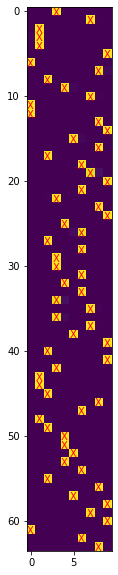

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(s.squeeze(2).detach().cpu().numpy())
for idx, x in enumerate(X):
    plt.text(x[-1]-0.5, idx+0.5, 'X', c='r')

## Appendix

Seq2Seq (sequence to sequence) nets map an arbitrary length input sequence to an arbitrary length output sequence. If one wanted to map an arbitrary length input sequence to an output sequence of the same length, then one can use one RNN/LSTM.

### Seq2Seq paper: https://arxiv.org/pdf/1409.3215.pdf

**Core idea**:

* Use LSTM (encoder) with multiple layers ("deep") to map input sequence -> vector of fixed dimensionality.

* Use another LSTM (decoder) with multiple layers to generate output sequence starting from vector of fixed dimensionality produced by encoder.

* Additional trick that improves performance significantly: feed both the input sequence and reversed input sequence (bidirectional) to the encoder.

**Core idea figure**:

![Seq2Seq](seq2seq.png)

**Example applications where input/output values are sequences of varying lengths**:

* Speech recognition: audio -> text

* Machine translation: text -> text

* Question answering: text -> text

**How to think about the encoder-decoder architecture**:

Encoder: Read input tokens one at a time and generate compressed context vector of fixed dimensionality.

Decoder: Conditioned on context vector, generate sequences. In other words, all information about the input sequence is passed to the decoder through the context vector.

**Model architecture**:

* LSTMs instead of RNNs

* Two different LSTMs are used i.e. the same LSTM weights are not used for the encoder and the decoder

* Multi-layer LSTMs are used: 4 layers

* Order of tokens/words is reversed in input sequence i.e. instead of mapping: a,b,c -> $\alpha,\beta,\gamma$, map c,b,a -> $\alpha, \beta, \gamma$ so that a is closer to $\alpha$, b is closer to $\beta$. But note that now c is further away from $\gamma$

**Dataset details**: To get a sense of scale

Trained on 12 million sentences

Total unique French words: 384 million

Total unique English words: 304 million

For predictions, output space of words was restricted to 160k words in the source language (English) and 80k words in the target language (French). If word not in vocabulary, replace by special unknown token, UNK.

**Training details**:

loss = $\frac{1}{\mid \mathcal{S} \mid} \Sigma_{(T,S)\in\mathcal{S}} \log p(T|S)$

where $\mathcal{S}$ is the training set.

In other words, for each training example, the source sentence S is used to predict the target sentence T. For each token in the prediction, we know the actual/label token that should have been predicted. Compute the log probability for the label token and add them up over the target sentence tokens. Average these across each example in the training set.

* LSTMs: 4 layers, 1000 cells (hidden_dim), 1000 dimensional word embeddings (embedding_dim), input vocabulary size = 160k, output vocabulary size = 80k.

* LSTM weights ~ uniform(-0.08, 0.08)

* SGD without momentum, lr = 0.7 for first 5 epochs and halve lr every half epoch

* Total training time = 7.5 epochs

* Batch size = 128

* For each batch, compute $s = \Vert g \Vert_2 / 128$ where g = gradient. If $s > 5$, set $g = \frac{5g}{s}$ i.e. if length of vector exceeds 5, rescale to make length = 5.

* Most sentences are short (20-30 tokens) and some are long (>100 tokens). Make sure sentences in each batch are roughly the same length to avoid wasted computation.

* Use model parallelism with different layers on different GPUs. Note this paper was written before TensorFlow, PyTorch, Theano (?) etc.

**Prediction/inference details**:

Beam search with size = 1 or 2 works well. In detail, the decoder is used to predict a probability distribution over all possible tokens at each time-step. Since the output of the decode at time t is the input to the decoder at time t+1, we need a sample from the distribution. 

Ideally, we want the output sequence to be such that the sum of the log probabilities of the sampled tokens is maximized. This is not the same as a greedy sampling strategy. Beam search keeps track of the top k running sums of log probabilities.

**Questions**:

* While training, how should the hidden state of the encoder be initialized?
    * Zeros for each batch
    * Make hidden state initialization learned?
    * Keep hidden state evolving as batches get processed? This sounds troublesome since the implication is the order in which sequences are processed, matters.

### Seq2Seq + Attention paper: https://arxiv.org/pdf/1409.0473.pdf

**Core idea**:

* In the encoder-decoder setup, some tokens in the decoder/output sequence are far away from the corresponding tokens in the encoder/input sequence.

* Since all context about the input is compressed into the context vector, it might lose information about earlier tokens. In other words, the context vector can be an information bottleneck.

* This manifests itself as poor performance when the length of the input sequence gets long (longer than training data sequences).

* Can each token in the decoder be allowed to search for relevant tokens in the input sentence? This search has to be soft i.e. predict probabilities over the input sequence rather than hard choices.

* In this paper, a mechanism (attention) is introduced where, at each time-step in the decoder, a soft search over all hidden states in the encoder is carried out. This search is used to generate a new appropriate context vector that focuses on subsets of the input sequence. In other words, there is no need to encode the full input sequence into *one* context vector. Instead each input sequence is encoded into a sequence of vectors and during decoding, a soft search is carried out over this sequence of vectors.

**Note**: 

While in the previous paper, the final hidden state in the decoder, $h_T$ is used as a context vector, as this paper suggests, one could generalize to:

$$c = q({h_1, \ldots, h_T})$$

i.e. the context vector is some (fixed) function of all the hidden states.

**Core idea figure**:

![Model](seq2seq_attention.png)

The $x_t$ are the input tokens to the encoder. The $h_t$ are the hidden states (bidirectional). The key difference is the computation of the decoder's hidden state at time t, $s_t$.

In the classic encoder-decoder picture, $s_t = f(s_{t-1}, y_{t-1})$. In this model,

$$s_t = f(s_{t-1}, y_{t-1}, h_{1}, h_{2}, \ldots, h_T)$$

where $f()$ sloppily refers to "some function" (not the same one in both computations). So, now the computation has direct access to each encoder hidden state.

**Precise formulation**:

Given an input sequence S, of length T, the encoder produces hidden states, $h_1, \ldots, h_T$.

These hidden states are used to compute a context vector, $c$. In the seq2seq paper, $c = h_T$.

The decoder conditions on the context vector i.e. it intializes its hidden state, $s_0$ so that $s_0 = c$.


The first token is a special SOS (start of sentence) token and is passed as the first input $y_0$. The decoder hidden state is updated:

$$s_1 = f(s_0, y_0)$$

which is used to compute the probability distribution over the vocabulary:

$$p(y_1\mid y_0, c) = g(s_1)$$


For any time t,

$$\boxed{s_t = f(s_{t-1}, y_{t-1})}$$

and $$\boxed{p(y_t\mid y_0,\ldots, y_{t-1}, c) = g(s_{t})}$$

Both of these equations implictly depend on the context vector $c$ since every calculation depends on $s_0 = c$. We make this explicit:

$$\boxed{s_t = f(s_{t-1}, y_{t-1}, c)}$$

and $$\boxed{p(y_t\mid y_0,\ldots, y_{t-1}, c) = g(s_{t}, c)}$$

One way of looking at attention is to make $c$ dependent on time t, i.e.:

$$\boxed{s_t = f(s_{t-1}, y_{t-1}, c_t)}$$

and $$\boxed{p(y_t\mid y_0,\ldots, y_{t-1}) = g(s_{t}, c_t)}$$


This implies an order of computation:

* Compute $c_t$ which is the context vector at time t.

* Compute hidden state $s_t$ from $c_t, s_{t-1}, y_{t-1}$.

* Compute prob distribution from $s_t, c_t$.

The context vector, instead of being just $h_T$ (last hidden vector in the encoder) is now generalized to a linear (convex) combination of all encoder hidden vectors:

$$c_t = \Sigma_{j} \alpha_{tj}h_j$$

where $\alpha_{tj}$ can be interpreted as probabilities as shown below.

$$\alpha_{tj} = \frac{e^{e_{tj}}}{\Sigma_{k}e^{e_{tk}}}$$

This is essentially a Boltzmann probability or you can think of $e_{tj}$ as the energy of the $j$th configuration, the exponential ensures that $\alpha_{tj} > 0$ and the denominator ensures the $\alpha_{tj}$ add up to 1 (when summed over $j$). 

The next question is how $e_{tj}$ is computed and there are many choices here. In general, $e_{tj} = a(s_{t-1}, h_j)$. Note that $e_{tj}$ is computed before $s_t$ and hence depends on $s_{t-1}$ and not $s_t$. In words, "based on what the decoder has generated so far till time t-1 and the summary encoded in $s_{t-1}$, what information can be gathered from the encoder's hidden states to compute the next hidden state $s_t$ so the next token can be computed".

**Open question**: what would happen if $s_t$ were used to compute $c_t$?


**Model architecture**:

Encoder: Bidirectional RNN (LSTM etc.)

Decoder: RNN (LSTM etc.) + Attention as described above

Loss: multi-class log loss/cross-entropy

Decoding strategy: Beam search

Optimizer: Adadelta (training time for paper's model ~ 5 days on what hardware?)

**Model details**: (See appendix)

**RNN**: Use LSTM or GRUs i.e. architectures that let one learn long-term dependencies since there are connections where the gradient is close to 1.

Recall $s_t = f(s_{t-1}, y_{t-1}, c_t)$ with a time-dependent context.

The precise computation used here is:

$$s_t = f(s_{t-1}, y_{t-1}, c_t) = (1-z_t) \odot s_{t-1} + z_t \odot \tilde{s}_t$$

where $\odot$ is element-wise multiplication, $z_t$ is the output of the update gates in the LSTM/GRU unit.

One way to think of this computation is as follows:

$z_t$ is a vector of numbers between 0 and 1 and hence is a soft mask or a vector of probabilities. It thereforce keeps elements of the previous state $s_{t-1}$ with probability $1-z_t$ and updates them with elements of a new hidden state candidate, $\tilde{s}_t$ with probability $z_t$.

The new candidate is defined to be:

$$\tilde{s}_t = \tanh(W e(y_{t-1}) + U [r_t \odot s_{t-1}] + C c_t)$$

Note that apart from using the reset gate, $r_t$, this is the usual computation of a hidden unit where $e(y_{t-1})$ is the embedding of the token from time $t-1$. At its simplest, this embedding is just one-hot encoding.

The two gates are computed using the same logic as any hidden recurrent unit:

$$z_t = \sigma(W_z e(y_{t-1}) + U_z s_{t-1} + C_z c_t)$$

$$r_t = \sigma(W_r e(y_{t-1}) + U_r s_{t-1} + C_r c_t)$$

and $\sigma$ is the sigmoid function to get values in range $(0,1)$.

**Computation of c_t**:

Recall that the context vector is a convex combination of the encoder's hidden states:

$$c_t = \Sigma_{j=1}^{T_x} \alpha_{tj} h_j$$ 

where the weights $\alpha_{tj}$ are computed using Boltzmann probabilities:

$$\alpha_{tj} = \frac{\exp(e_{tj})}{\Sigma_k \exp(e_{tk})}$$

and the energies, $e_{tj}$ are:

$$e_{tj} = a(s_{t-1}, h_j)$$

There are many choices for $a()$. The one made by this paper is:

$$e_{tj} = a(s_{t-1}, h_j) = v_a^T \tanh(W_a s_{t-1} + U_a h_j)$$

Here, $v_a, W_a, U_a$ are learned parameters. You can think of $e_{tj}$ as a similarity score between $s_{t-1}$ and $h_j$. The matrices $W_a$ and $U_a$ map $s_{t-1}$ and $h_j$ respectively, to the same vector space so they can be added together. Note, another simple choice could be:

$$e_{tj} = s_{t-1}^T W_a h_j$$


**Training details**: 

* All recurrent weight matrices are initialized as random orthogonal matrices ($U^T U = I$)

* $W_a$ and $U_a$ have each element drawn from a gaussian distribution, $\mathcal{N}(0, 0.001^2)$

* Biases and $V_a$ were initialized to zero.

* Any other weight matrices had elements drawn from $\mathcal{N}(0, 0.01^2)$

* Adadelta (adaptive SGD algorithm) was used with parameters ($\epsilon = 10^{-6}$ and $\rho = 0.95$)

* Gradients were restricted to be at most of $L_2$ norm = 1

* Batch size = 80 sentences

* Every 20th update, 20*80 = 1600 sentences were retrieved, sorted by sequence length and split into 20 batches for the next 20 updates. This is because the time spent on a batch was proportional to the length of the longest sequence.

* Training data shuffled once before training